In [114]:
import numpy as np
import scipy.optimize as opt
import PS7 as demog
import time
import matplotlib.pyplot as plt
import pandas as pd

## Problem 1

In [115]:
# Household Parameters
E = 20
S = 80
beta_annual = .96
beta = beta_annual ** (80 / S)
sigma = 2.2
nvec = np.ones(S)
cut = round(2 * S / 3)
nvec[cut: ] = 0.2
chi_vec_bq = np.ones(S)

# Firm Parameters
alpha = 0.35
A = 1.0
delta_annual = 0.05
delta = 1- ((1 - delta_annual) ** (80 / S))

# Economic Growth
g_y = 0.03
T = 300

# Population
pop_data = pd.read_table('pop_data.csv', sep=',', thousands=',')
pop_now = np.array(pop_data['2013'][E:-1])
fert_rate, mort_rate, inf_mort, imm_rates_orig, OMEGA_orig, omega_SS, g_n_SS = demog.get_dist_stable(E, S)
omega_SS = omega_SS[E:]
mort_rate = mort_rate[E:]
g_n_path, omega_path_new, imm_rate = demog.get_dist_path(E, S, T)
imm_SS = imm_rate[:,-1]

# Define functions for calculating L, K, w, r, Y

def get_L(nvec, omega_SS): # function for aggregate labor
    L = (omega_SS * nvec).sum()
    return L

def get_K(bvec, omega_SS, g_n_SS, imm_SS):
    K = (1 / (1 + g_n_SS)) * (omega_SS[:-1] * bvec + imm_SS[1:] * omega_SS[1:] * bvec).sum()
    return K

def get_BQ(bvec, r, g_n_SS, omega_SS, mort_rate):
    BQ = ((1 + r) / (1 + g_n_SS)) * (mort_rate[:-1] * omega_SS[:-1] * bvec).sum()
    return BQ

def get_w(K, L, params): # function for wage
    A, alpha = params
    w = (1 - alpha) * A * ((K / L) ** alpha)
    return w

def get_r(K, L, params): # function for interest rate
    A, alpha, delta = params
    r = alpha * A * ((L / K) ** (1 - alpha)) - delta
    return r

def get_C(cvec, omega_SS):
    C = (omega_SS * cvec).sum()
    return C

def get_I(K, K1, bvec, delta, g_n_SS, omega_SS, imm_SS, g_y):
    I = (1 + g_n_SS) * np.exp(g_y) * (K1 - (imm_SS[1:] * omega_SS[1:] * bvec).sum()) - (1 - delta) * K
    return I

def get_Y(K, L, params): # function for output
    A, alpha = params
    Y = A * (K ** alpha) * (L ** (1 - alpha))
    return Y

In [116]:
def errors(bvec, *args):

    A, nvec, beta, sigma, alpha, A, delta, g_n_SS, omega_SS, imm_SS, mort_rate, g_y = args
    L = get_L(nvec, omega_SS)
    K = get_K(bvec, omega_SS, g_n_SS, imm_SS)
    w = get_w(K, L, (A, alpha))
    r = get_r(K, L, (A, alpha, delta))
    
    BQ = get_BQ(bvec, r, g_n_SS, omega_SS, mort_rate)
    b = np.append(0, bvec)
    b1 = np.append(bvec, 0)
    cvec = (1 + r) * b + w * nvec + BQ - np.exp(g_y) * b1

    muc = cvec ** (-sigma)
    errors = muc[:-1] - (np.exp(-sigma * g_y) * (1 - mort_rate[:-1]) * beta * (1 + r) * muc[1:])
    
    return errors


 Savings: 			 [0.06, 0.11, 0.17, 0.23, 0.29, 0.34, 0.4, 0.46, 0.52, 0.58, 0.64, 0.7, 0.76, 0.83, 0.89, 0.95, 1.01, 1.08, 1.14, 1.21, 1.28, 1.34, 1.41, 1.48, 1.56, 1.63, 1.71, 1.78, 1.87, 1.95, 2.04, 2.13, 2.23, 2.33, 2.43, 2.55, 2.67, 2.8, 2.94, 3.09, 3.25, 3.42, 3.61, 3.81, 4.03, 4.28, 4.54, 4.83, 5.15, 5.5, 5.88, 6.31, 6.78, 6.57, 6.35, 6.11, 5.87, 5.61, 5.33, 5.05, 4.75, 4.45, 4.13, 3.81, 3.48, 3.15, 2.82, 2.49, 2.17, 1.85, 1.55, 1.27, 1.01, 0.77, 0.55, 0.37, 0.23, 0.12, 0.04] 
 Capital and Labor: 		 [ 1.88  0.66] 
 Wage and Interest rate: 	 [ 0.94  0.13] 
 Consumption: 			 [0.93, 0.93, 0.94, 0.94, 0.95, 0.95, 0.96, 0.96, 0.97, 0.97, 0.98, 0.98, 0.99, 0.99, 1.0, 1.01, 1.01, 1.02, 1.02, 1.03, 1.03, 1.04, 1.04, 1.05, 1.05, 1.06, 1.06, 1.07, 1.07, 1.08, 1.08, 1.09, 1.09, 1.1, 1.1, 1.1, 1.11, 1.11, 1.11, 1.12, 1.12, 1.12, 1.12, 1.12, 1.12, 1.13, 1.13, 1.13, 1.12, 1.12, 1.12, 1.12, 1.11, 1.11, 1.1, 1.09, 1.08, 1.07, 1.06, 1.05, 1.03, 1.01, 0.99, 0.97, 0.94, 0.91, 0.88, 0.85, 0.81, 0.77,

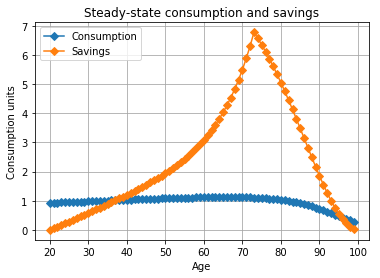

In [117]:
def get_SS(params, bvec_guess, SS_graphs = False):

    start_time = time.clock()

    A, nvec, beta, sigma, alpha, A, delta, g_n_SS, omega_SS, imm_SS, mort_rate, g_y = params

    b = opt.root(errors, bvec_guess, args = (A, nvec, beta, sigma, alpha, A, delta, g_n_SS, omega_SS, imm_SS, mort_rate, g_y), tol = SS_tol)
    if b.success:
        b_ss = b.x
    else:
        raise ValueError("Failed to find b_ss")

    L_ss = get_L(nvec, omega_SS)
    K_ss = get_K(b_ss, omega_SS, g_n_SS, imm_SS)
    w_ss = get_w(K_ss, L_ss, (A, alpha))
    r_ss = get_r(K_ss, L_ss, (A, alpha, delta))

    BQ_ss = get_BQ(b_ss, r_ss, g_n_SS, omega_SS, mort_rate)
    b = np.append(0, b_ss)
    b1 = np.append(b_ss, 0)
    c_ss = (1 + r_ss) * b + w_ss * nvec + BQ_ss - np.exp(g_y) * b1
    
    muc = c_ss ** (-sigma)
    EulErr_ss = muc[:-1] - (np.exp(-sigma * g_y) * (1 - mort_rate[:-1]) * beta * (1 + r_ss) * muc[1:])
    
    Y_ss = get_Y(K_ss, L_ss, (A, alpha))
    C_ss = get_C(c_ss, omega_SS)
    I_ss = get_I(K_ss, K_ss, b_ss, delta, g_n_SS, omega_SS, imm_SS, g_y)
    RCerr_ss = Y_ss - C_ss - I_ss

    ss_time = time.clock() - start_time

    ss_output = {
        'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss,
        'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss, 'BQ_ss': BQ_ss,
        'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
        'ss_time': ss_time}

    b = [float(i) for i in ["%.2f" % v for v in b_ss]]
    L = float("{0:.2f}".format(L_ss))
    K = float("{0:.2f}".format(K_ss))
    w = float("{0:.2f}".format(w_ss))
    r = float("{0:.2f}".format(r_ss))
    c = [float(i) for i in ["%.2f" % v for v in c_ss]]

    print('\n Savings: \t\t\t {} \n Capital and Labor: \t\t {} \n Wage and Interest rate: \t {} \n Consumption: \t\t\t {}'.format(b, np.array([K, L]), np.array([w, r]), c))
    print('Bequest:  ', BQ_ss)
    print('Euler errors: ', EulErr_ss)
    print('Resource Constraint error: ', RCerr_ss)
    print('Time needed: ', ss_time)

    if SS_graphs:
        age = np.arange(E, E + S)
        fig, ax = plt.subplots()
        plt.plot(age, c_ss, marker='D',label='Consumption')
        plt.plot(age, np.append([0], b_ss), marker = 'D', label='Savings')
        plt.grid(b=True, which='major', color='0.65', linestyle='-')
        plt.title('Steady-state consumption and savings')
        plt.xlabel('Age')
        plt.ylabel('Consumption units')
        plt.legend()
        plt.show()

    return ss_output

SS_tol = 1e-9

params = (A, nvec, beta, sigma, alpha, A, delta, g_n_SS, omega_SS, imm_SS, mort_rate, g_y)
bvec_guess = np.ones(79) * 0.1
SS = get_SS(params, bvec_guess, SS_graphs = True)

## Problem 2

In [118]:
# TPI params
max_iter = 300
tol = 1e-9
xi = 0.3
b_ss = SS['b_ss']
K_ss = SS['K_ss']
w_ss = SS['w_ss']
r_ss = SS['r_ss']
BQ_ss = SS['BQ_ss']
L_ss = get_L(nvec, omega_SS)

# Initial guess for capital stock
weights = ((1.5 - 0.87) / 78) * np.arange(S - 1) + 0.87
b1vec = weights * b_ss
K1 = get_K(b1vec, pop_now/pop_now.sum(), g_n_path[0], imm_rate[:,0])
Kpath_old = np.zeros(T + S - 1)
Kpath_old[:T] = np.linspace(K1, K_ss, T) # Until reaching steady state
Kpath_old[T:] = K_ss
r = get_r(Kpath_old, L_ss, (A, alpha, delta))
BQ1 = get_BQ(b1vec, r[0], g_n_path[0], pop_now/pop_now.sum(), mort_rate)
BQpath_old = np.zeros(T + S - 1)
BQpath_old[:T] = np.linspace(BQ1, BQ_ss, T) # Until reaching steady state
BQpath_old[T:] = BQ_ss

In [119]:
def MU_c_stitch(cvec, sigma):
    epsilon = 1e-4
    muc = cvec ** (-sigma)
    m1 = (-sigma) * epsilon ** (-sigma - 1)
    m2 = epsilon ** (-sigma) - m1 * epsilon
    c_cnstr = cvec < epsilon
    muc[c_cnstr] = m1 * cvec[c_cnstr] + m2   
    return muc

def get_errors(bvec, *args):
    
    beg_wealth, nvec, beta, sigma, w_path, r_path, BQ_path, mort_rate, g_y = args
    b1 = np.append(beg_wealth, bvec)
    b2 = np.append(bvec, 0)
    cvec = (1 + r_path) * b1 + w_path * nvec + BQ_path - np.exp(g_y) * b2
    muc = MU_c_stitch(cvec, sigma)
    errors = muc[:-1] - np.exp(-sigma * g_y) * beta * (1 + r_path[1:]) * (1 - mort_rate[:-1]) * muc[1:]
    return errors

In [120]:
abs2 = 1
tpi_iter = 0
mort_rate_mat = np.tile(mort_rate.reshape(S, 1), (1, T + S - 1))
while abs2 > tol and tpi_iter < max_iter:
    Kpath_old[T:] = K_ss
    BQpath_old[T:] = BQ_ss
    tpi_iter = tpi_iter + 1
    wpath = get_w(Kpath_old, L_ss, (A, alpha))
    rpath = get_r(Kpath_old, L_ss, (A, alpha, delta))
    # Initialize savings matrix
    b = np.zeros((S - 1, T + S - 1))
    b[:, 0] = b1vec

    # Solve the incomplete remaining lifetime decisions of agents alive
    # in period t=1 but not born in period t=1
    for p in range(2, S):
        bvec_guess = np.diagonal(b[S - p:, :p - 1]) # Initial guess of the lifetime savings path for individual with p periods to live
        beg_wealth = b[S - p - 1, 0]
        args_bp = (beg_wealth, nvec[-p:], beta, sigma, wpath[:p], rpath[:p], BQpath_old[:p], mort_rate[-p:], g_y)
        bp = opt.root(get_errors, bvec_guess, args = (args_bp), method = 'lm').x
    # Insert the vector lifetime solutions diagonally (twist donut)
        DiagMaskbp = np.eye(p - 1)
        bp_path = DiagMaskbp * bp
        b[S - p:, 1:p] += bp_path

    # Solve for complete lifetime decisions of agents born in periods
    # 1 to T
    for t in range(1, T + 1):
        bvec_guess = np.diagonal(b[:, t - 1:S + t - 2])
        args_bt = (0, nvec, beta, sigma, wpath[t - 1 : S + t - 1], rpath[t - 1 : S + t - 1], \
                  BQpath_old[t - 1:t + S - 1], mort_rate, g_y)
        bt = opt.root(get_errors, bvec_guess, args = (args_bt)).x
        DiagMaskbt = np.eye(S - 1)
        bt_path = DiagMaskbt * bt
        b[:, t: S + t - 1] += bt_path
    # Calculate the implied capital stock from conjecture and the error
    Kpath_new = (1 / (1 + g_n_path[1:])) * (omega_path_new[:-1, :-1] * b + imm_rate[1:, 1:] *\
                     omega_path_new[1:,:-1] * b).sum(axis=0)
    Kpath_new[0] = K1
    BQpath_new = ((1 + rpath) / (1 + g_n_path[1:])) * ((mort_rate_mat[:-1,:] * omega_path_new[:-1, :-1] * b).sum(axis=0))
    BQpath_new[0] = BQ1
    abs2 = (((Kpath_old[:T] - Kpath_new[:T])/ Kpath_old[:T] * 100) ** 2).sum()+\
           (((BQpath_old[:T] - BQpath_new[:T]) / BQpath_old[:T] * 100) ** 2).sum()
    
    # Update guess
    Kpath_old = xi * Kpath_new + (1 - xi) * Kpath_old
    BQpath_old = xi * BQpath_new + (1 - xi) * BQpath_old
    print('iteration:', tpi_iter, ' squared distance: ', abs2)

iteration: 1  squared distance:  1583484.46182
iteration: 2  squared distance:  1555880.39387
iteration: 3  squared distance:  384120.40949
iteration: 4  squared distance:  296984.937631
iteration: 5  squared distance:  99998.4024252
iteration: 6  squared distance:  66422.6382996
iteration: 7  squared distance:  25461.8066631
iteration: 8  squared distance:  15503.35755
iteration: 9  squared distance:  6273.62465091
iteration: 10  squared distance:  3602.46798715
iteration: 11  squared distance:  1476.82014339
iteration: 12  squared distance:  804.461307809
iteration: 13  squared distance:  323.26548235
iteration: 14  squared distance:  166.210522214
iteration: 15  squared distance:  63.7356597897
iteration: 16  squared distance:  30.9612815863
iteration: 17  squared distance:  11.159747492
iteration: 18  squared distance:  5.18435967187
iteration: 19  squared distance:  1.7455787183
iteration: 20  squared distance:  0.790898647993
iteration: 21  squared distance:  0.247937567827
itera

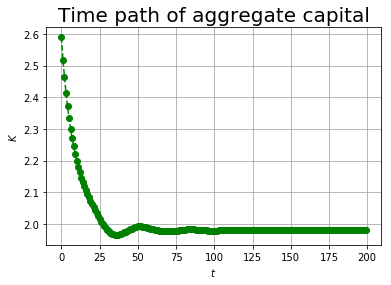

In [125]:
plt.plot(np.arange(200), Kpath_old[:200], 'go--')
plt.grid(b=True, which='major', color='0.65', linestyle='-')
plt.title('Time path of aggregate capital', fontsize=20)
plt.xlabel(r'$t$')
plt.ylabel(r'$K$')
plt.show()

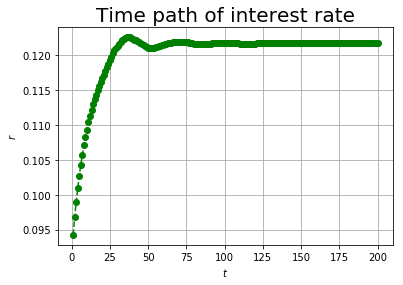

In [122]:
plt.plot(1 + np.arange(200), rpath[:200], 'go--')
plt.grid(b=True, which='major', color='0.65', linestyle='-')
plt.title('Time path of interest rate', fontsize=20)
plt.xlabel(r'$t$')
plt.ylabel(r'$r$')
plt.show()

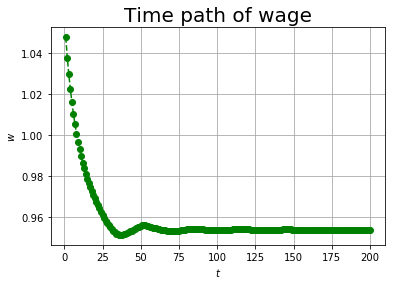

In [126]:
plt.plot(1 + np.arange(200), wpath[:200], 'go--')
plt.grid(b=True, which='major', color='0.65', linestyle='-')
plt.title('Time path of wage', fontsize=20)
plt.xlabel(r'$t$')
plt.ylabel(r'$w$')
plt.show()